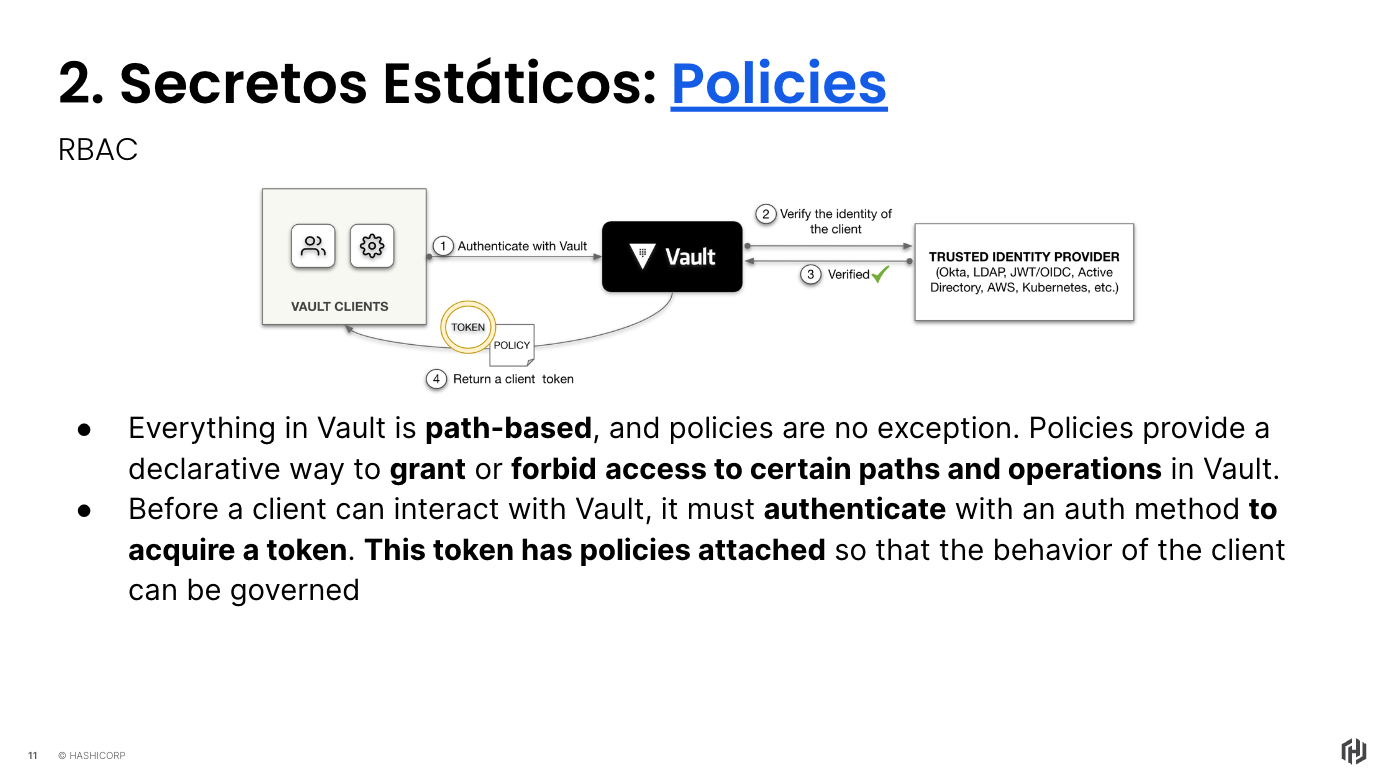

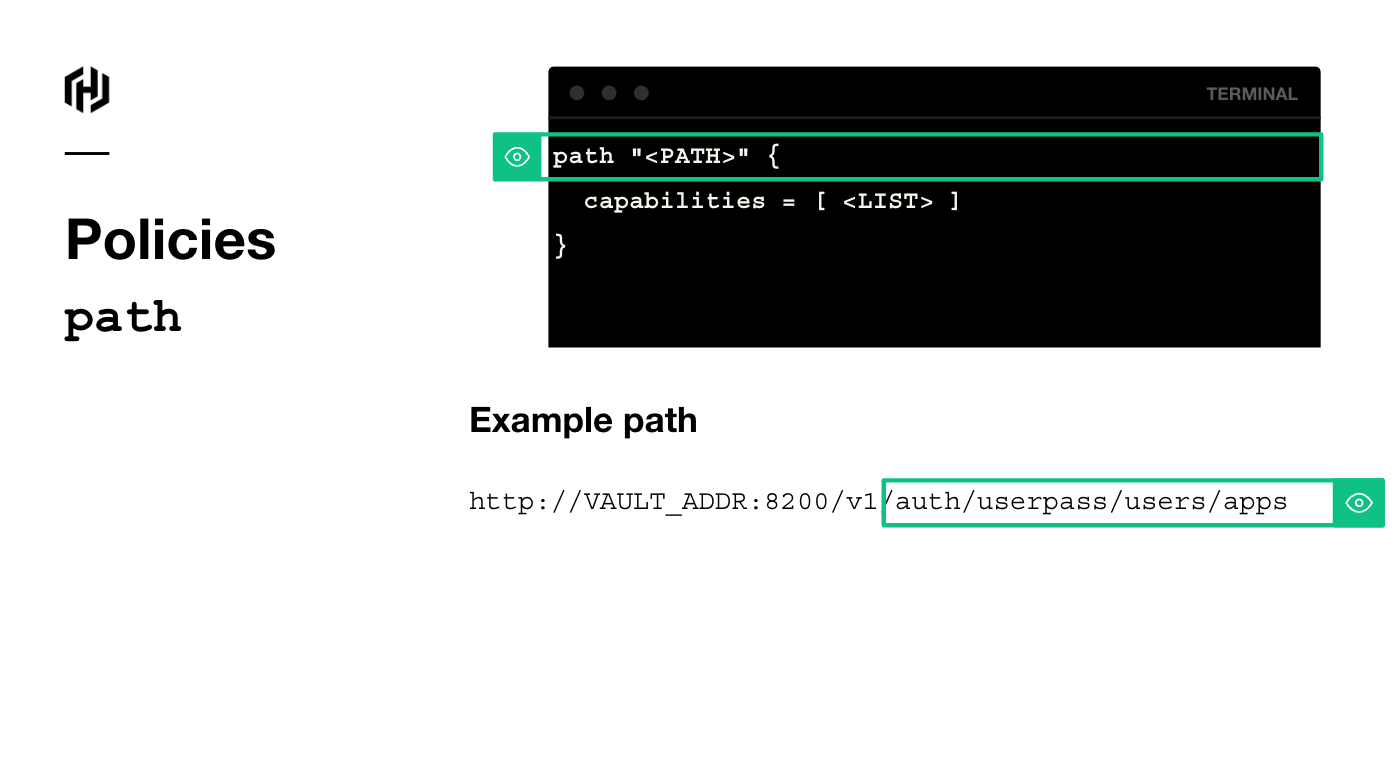

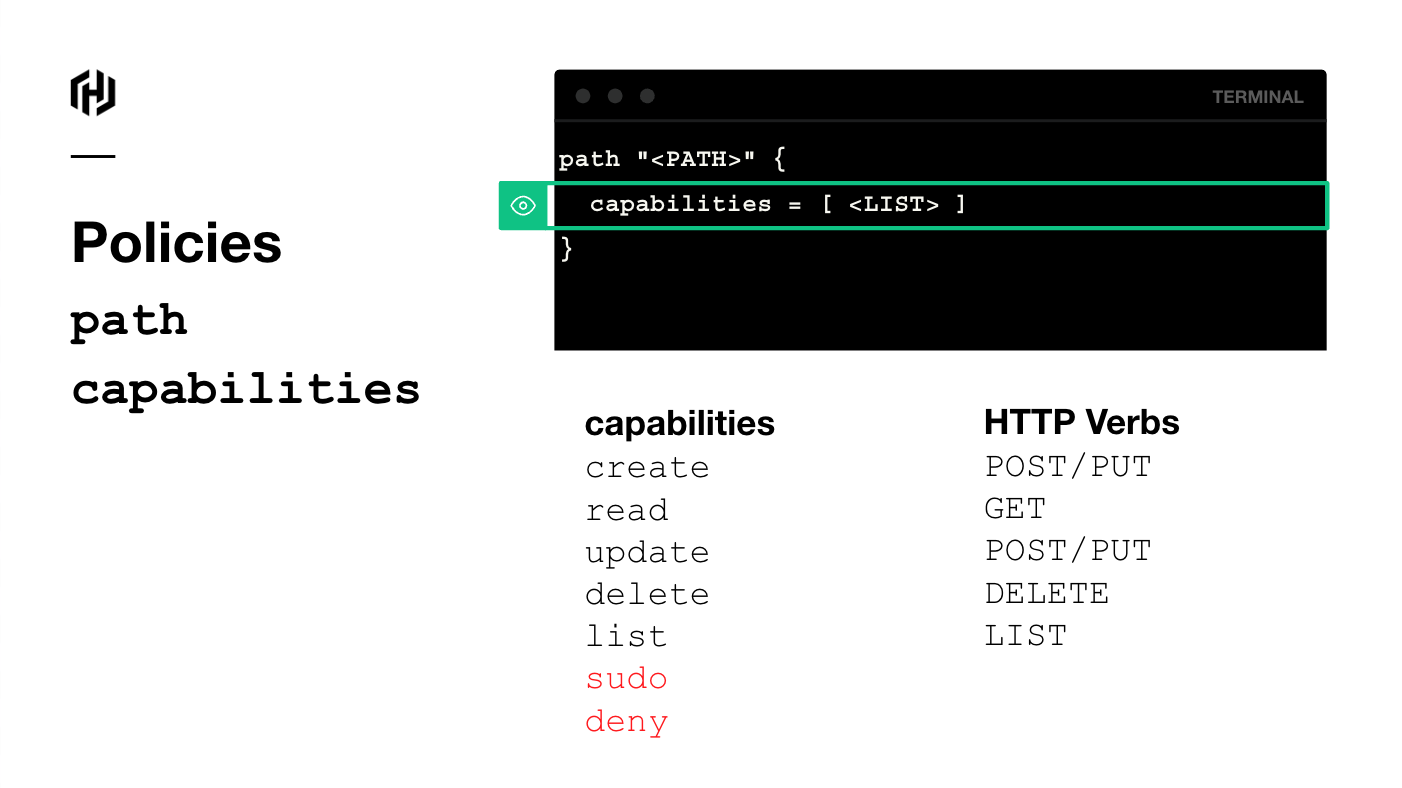

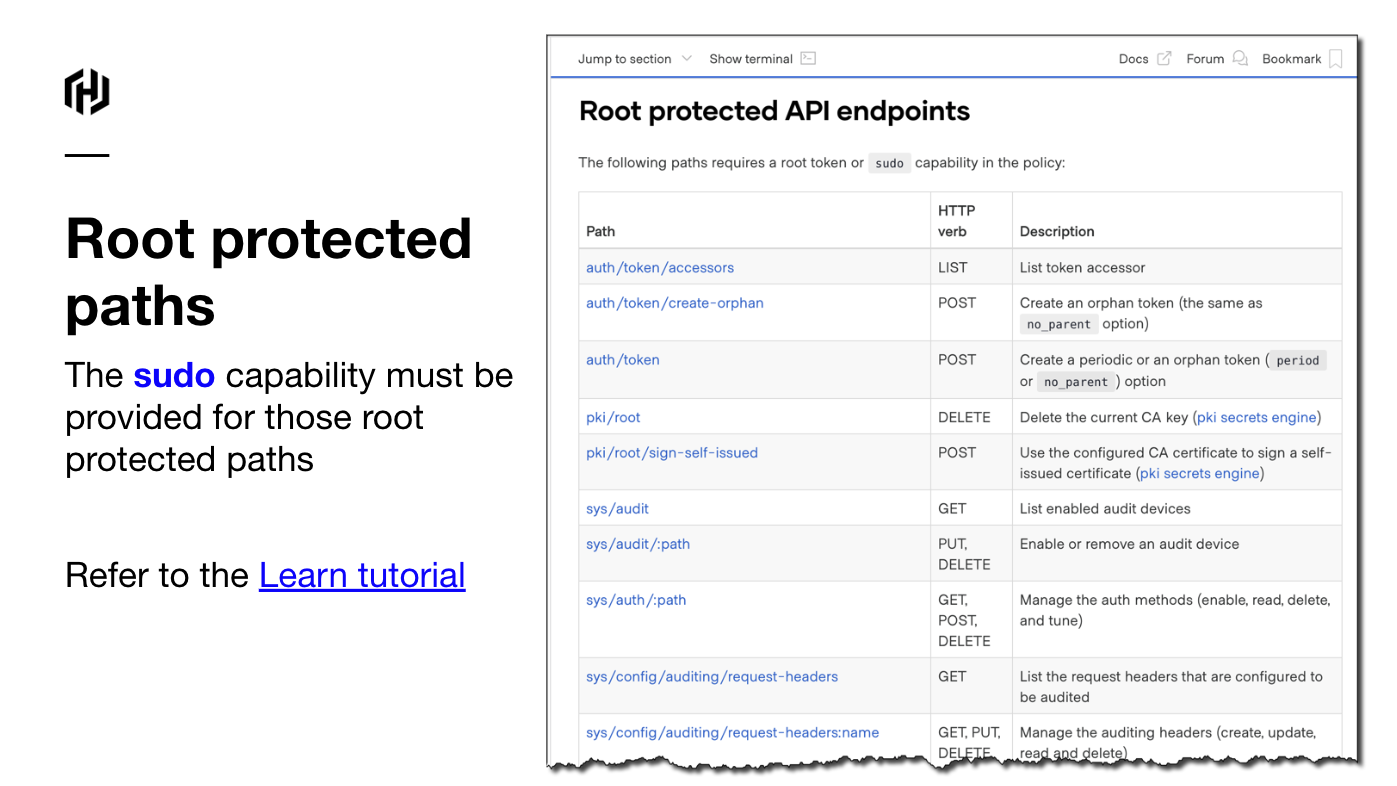

In [ ]:
%env  WORKDIR=/tmp/vault

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.kABdKt9HrZusmhHhIbqQSB8W
%env VAULT_CACERT=/tmp/vault/vault.ca

In [ ]:
%%bash
kubectl apply -f openldap_deployment.yml

In [ ]:
%%bash
vault auth enable ldap

In [ ]:
%%bash
vault write auth/ldap/config \
    binddn="cn=admin,dc=learn,dc=example" \
    bindpass="2LearnVault" \
    url="ldap://openldap:389" \
    userdn="ou=users,dc=learn,dc=example" \
    userattr="cn" \
    userfilter="({{.UserAttr}}={{.Username}})" \
    groupdn="dc=learn,dc=example"\
    groupfilter="(&(objectClass=person)(cn={{.Username}}))" \
    groupattr="memberOf"\
    insecure_tls=true


In [ ]:
%%bash
vault write auth/ldap/groups/dev policies=dev
vault write auth/ldap/groups/ops policies=ops

In [ ]:
%%bash

cat >  $WORKDIR/dev_policy.hcl <<EOF

path "secret/*" {
  capabilities = ["list"]
}

path "secret/data/*" {
  capabilities = ["list"]
}
path "secret/metadata/*" {
  capabilities = [ "list"]
}

path "secret/data/dev" {
  capabilities = ["list"]
}
# Can create secret on secret/dev only
path "secret/data/dev/*" {
  capabilities = ["create", "update", "read", "list"]
}
path "secret/metadata/dev/*" {
  capabilities = ["read", "create", "update", "list"]
}
 
# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}
EOF

#---

cat >  $WORKDIR/ops_policy.hcl <<EOF

path "secret/*" {
  capabilities = ["list"]
}
# To allow a policy to delete data
path "secret/delete/*" {
  capabilities = ["update"]
}
# To allow a policy to undelete data
path "secret/undelete/*" {
  capabilities = ["update"]
}
#To allow a policy to destroy versions
path "secret/destroy/*" {
  capabilities = ["update"]
}

path "secret/data/*" {
  capabilities = ["create", "update", "read", "list", "patch"]
}
# list To allow a policy to list keys:
# read to view metada
# delete To allow a policy to permanently remove all versions and metadata for a key:
path "secret/metadata/*" {
  capabilities = ["read", "create", "update", "list", "patch", "delete"]
}

# Enable secrets engine
path "sys/mounts/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}

EOF

vault policy write dev $WORKDIR/dev_policy.hcl
vault policy write ops $WORKDIR/ops_policy.hcl


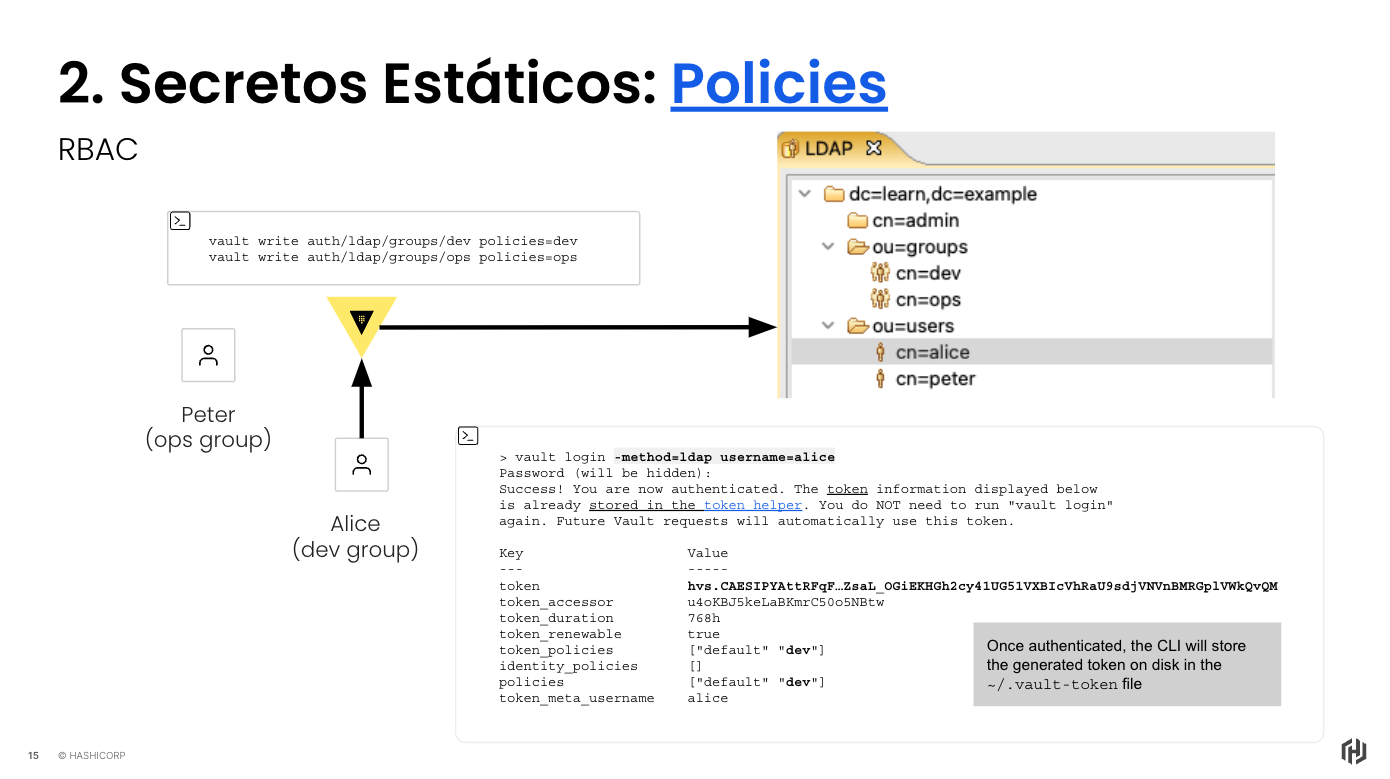

## Ahora con namespaces

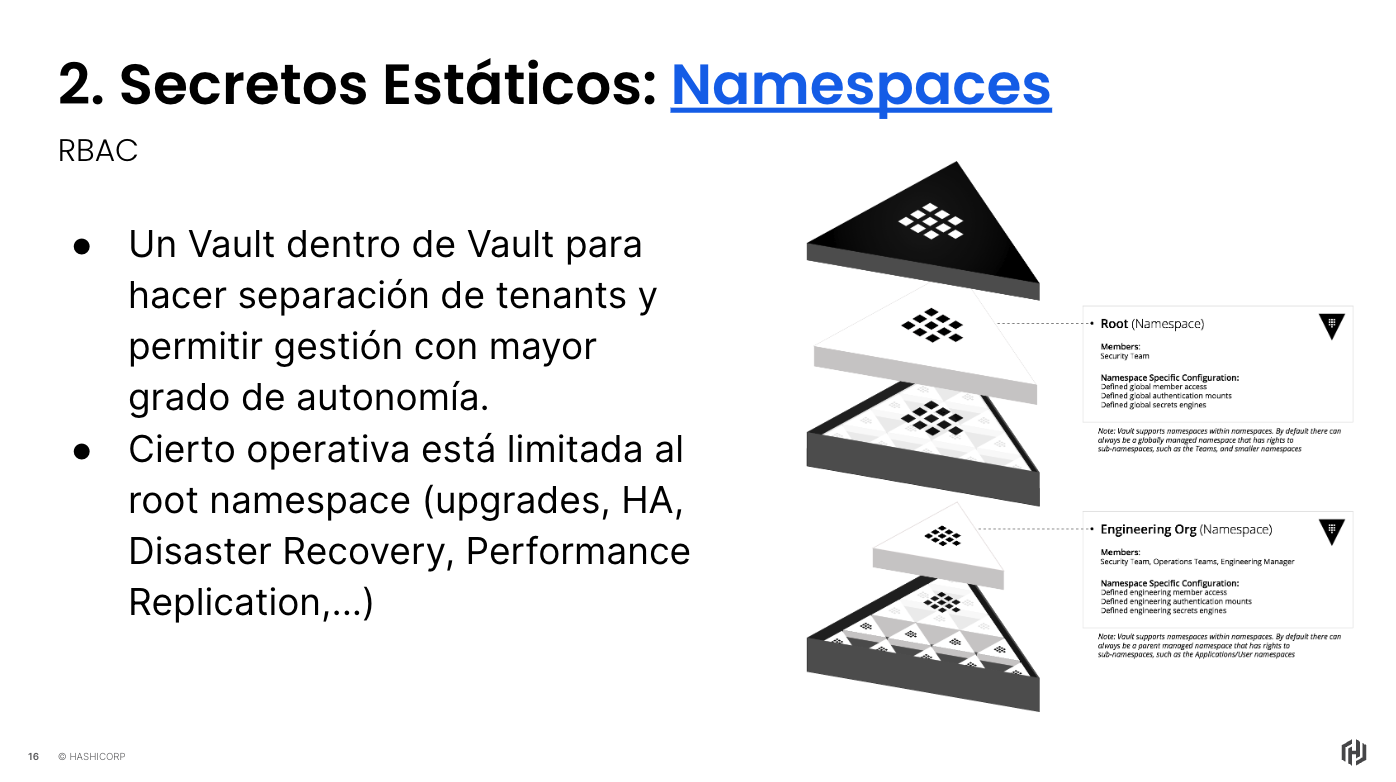

In [ ]:
%%bash
vault namespace create dev/
vault namespace create ops/

In [ ]:
%%bash
# Configure Vault to use namespace
export VAULT_NAMESPACE=ops
# enable Auth Method
vault auth enable ldap
# Configure LDAP Auth

vault write  auth/ldap/config \
    binddn="cn=admin,dc=learn,dc=example" \
    bindpass="2LearnVault" \
    url="ldap://openldap:389" \
    userdn="ou=users,dc=learn,dc=example" \
    userattr="cn" \
    userfilter="({{.UserAttr}}={{.Username}})" \
    groupdn="dc=learn,dc=example"\
    groupfilter="(&(objectClass=person)(cn={{.Username}}))" \
    groupattr="memberOf"\
    insecure_tls=true

vault write auth/ldap/groups/ops policies=ops

cat > $WORKDIR/ops_namespace_policy.hcl <<EOF
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
   capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}

# Create and manage entities and groups
path "identity/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# Manage tokens
path "auth/token/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets at 'ops'
path "secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

EOF

# Apply policy to users part of LDAP group ops
vault policy write ops $WORKDIR/ops_namespace_policy.hcl


In [ ]:
%%bash
# Configure Vault to use namespace
export VAULT_NAMESPACE=dev
# enable Auth Method
vault auth enable ldap
# Configure LDAP Auth

vault write auth/ldap/config \
    binddn="cn=admin,dc=learn,dc=example" \
    bindpass="2LearnVault" \
    url="ldap://openldap:389" \
    userdn="ou=users,dc=learn,dc=example" \
    userattr="cn" \
    userfilter="({{.UserAttr}}={{.Username}})" \
    groupdn="dc=learn,dc=example"\
    groupfilter="(&(objectClass=person)(cn={{.Username}}))" \
    groupattr="memberOf"\
    insecure_tls=true

vault write auth/ldap/groups/dev policies=dev

cat > $WORKDIR/dev_namespace_policy.hcl <<EOF
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
   capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}

# Create and manage entities and groups
path "identity/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# Manage tokens
path "auth/token/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets at 'ops'
path "secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

EOF

# Apply policy to users part of LDAP group ops
vault policy write dev $WORKDIR/dev_namespace_policy.hcl
